<a href="https://colab.research.google.com/github/mannixp/Plumes/blob/main/Stochastic_Plume_Model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We load the neccessary libraries, specifiy the domain $z \in [0,1]$ and the differentiation matrices $D = d/dz$ and $L = d^2/dz^2$.

In [67]:
from scipy.integrate   import solve_ivp
from scipy.ndimage     import gaussian_filter
from scipy.interpolate import interp1d
import numpy as np
import matplotlib.pyplot as plt
import numba as nb

ε    = 1e-12
π    = np.pi
Npts = 64

z = np.linspace(0+ε,1-ε,Npts)

I = np.eye(Npts) # I
D = np.zeros((Npts,Npts)) # D = d/dz
L = np.zeros((Npts,Npts)) # L = d2/dz2
for i,z_i in enumerate(z):

    if i == 0:
      #D
      D[i,i+1] =  1

      #L
      L[i,i  ] = -2
      L[i,i+1] =  2 # if db/dz = 0
    elif i == Npts-1:
      #D
      D[i,i-1] = -1

      # L
      L[i,i-1] =  2 # if db/dz = 0
      L[i,i  ] = -2
    else:
      # D
      D[i,i-1] = -1
      D[i,i+1] =  1

      # L
      L[i,i-1] =  1
      L[i,i  ] = -2
      L[i,i+1] =  1

dz = z[1] - z[0]
L /= dz**2
D /= 2*dz

From the plume equations
\begin{align*}
\frac{dF}{dz} &= -\frac{d b}{d z} Q, \\
\frac{dQ}{dz} &= \frac{Q}{z} + \frac{3^4}{2^6} \frac{\delta^4 \pi^2 z^4}{Q^2} F, \\
\end{align*}
where $F(z)$ and $Q(z)$ are the horizontally averaged (steady) buoyancy flux and volume flux respectively. This model contains two free parameters the Buoyancy frequency $N^2(z) = \frac{d b}{d z}$ which characterises the background vertical stratification and the dimensionless turbulence production coefficient $\delta < 0$. These equations are implemented below.

In [68]:
@nb.njit()
def plume_eqns(z,X,z_i,dbdz_i,plume_type,δ=-0.25):

    """
    F,Q  = X
    """

    dX    = 0*X
    if plume_type == "Rise":
      dX[0] = -np.interp(z,z_i,dbdz_i)*X[1];
    elif plume_type == "Sink":
      dX[0] = -np.interp(1-z,z_i,dbdz_i)*X[1];

    dX[1] = X[1]/z + ((3**4)/(2**6))*( ((z**4)*(δ**4)*(π**2))/(X[1]**2) )*X[0]
    return dX;

To solve these equations we first set up an ode solver using scipy, which for a rising plume takes as initial conditions
\begin{align*}
Q(z=0) &= Q_0, \\
F(z=0) &= P_{F|Q}(f|q=Q_0,z=0) = \mathcal{N}(\mu=F_0,\sigma^2=0.1\mu)
\end{align*}
where the buoyancy flux is drawn from a normal distribution centered around $F_0$ with a variance that is 10% of the mean. The equations are then solved from $z=0 \to 1$ until $F=0$ at which point the integration is terminated. This corresponds to the plume attaining its neutrally buoyant height. For a descending plume we specifiy the above conditions at $z=1$ and integrate from $z=1 \to 0$ until $F=0$. \\

As $F(z=0,1)$ is given by a distribution, we make use of a Monte-Carlo approach in order to obtain the average solution. This consists of running whereby a large ensemble of initial conditions and then averaging over the ensemble of their solutions.

In [69]:
def Plot_F_and_Q(f,q,label_f='$F(z)$',label_q='$Q(z)$'):

  fig, (ax1, ax2) = plt.subplots(1, 2)

  ax1.plot(z[1:-1], f[1:-1], 'b')
  ax1.set_xlabel(r'$z$')
  ax1.set_ylabel(label_f)
  plt.grid()

  ax2.plot(z[1:-1], q[1:-1], 'r')
  ax2.set_xlabel(r'$z$')
  ax2.set_ylabel(label_q)
  plt.grid()

  plt.tight_layout()
  plt.show()

  return None;

def N(μ=0,σ=.1,samples = 10**2):

  """
  Generate N_samples from a Normal distribution

  N(μ,σ2)

  of mean μ and standard deviation σ.

  """

  return np.random.default_rng().normal(loc=μ,scale=σ,size=samples)

def Plume_Solve(F0,dbdz):

    def event(t,y,*args): return y[0];
    event.terminal = True;
    event.positive = 0

    if F0 < 0:
      plume_type = "Sink"
    elif F0 >0:
      plume_type = "Rise"

    # Solver
    sol  = solve_ivp(fun=plume_eqns,t_span=[z[0],z[-1]], y0=[abs(F0),ε], t_eval=z,args=(z,dbdz,plume_type),events=event)

    F = 0.*z;
    Q = 0.*z;
    if F0 > 0.:
      F[0:len(sol.y[0])] = sol.y[0]
      Q[0:len(sol.y[1])] = sol.y[1]
    elif F0 < 0.:
      F[Npts-len(sol.y[0]):] =     sol.y[0][::-1]
      Q[Npts-len(sol.y[1]):] = -1.*sol.y[1][::-1]

    return F,Q

def Plume_Solve_Monte_Carlo(F0,Nsq,samples = 10**2):

  # Get the samples
  std_dev = (abs(F0)/10.) # 10% of the mean
  μ       = F0
  F_0     = N(μ=μ,σ=std_dev,samples=samples)

  # print('Checking distribution mu,std_dev=',abs(μ - np.mean(F_0)),abs(std_dev - np.std(F_0) ))
  # plt.hist(F_0, bins=30, density=True)
  # plt.show()

  # Containers for the solution
  Q = 0*z
  F = 0*z

  for f_0 in F_0:
    Fi,Qi  = Plume_Solve(f_0,Nsq)
    F+=Fi; Q+=Qi

  F /=samples
  Q /=samples

  return F,Q

def Plume_Solve_Fokker_Planck(F0,Nsq,samples = 10**2):

  raise NotImplementedError

Generate rising and descending plumes: (1) using a deterministic approach with a fixed initial condition $F_i$

In [ ]:
# Initial conditions
Nsq    = 1*(z/z)
Plumes = {'F1':.1,'F2':-.1}

Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve(F_value,Nsq)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

(2) using a Monte-Carlo approach by sampling from a normal distribution of mean $F_i$ and standard deviation 10% of the mean.

In [ ]:
Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve_Monte_Carlo(F_value,Nsq,samples = 10**3)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

(3) solving the Fokker-Planck equation
\begin{equation}
    \frac{\partial }{\partial z} P_{FQ} = -\frac{\partial }{\partial f} \left[ \left(-N^2(z) q \right) P_{FQ} \right] -\frac{\partial }{\partial q} \left[ \left( \frac{q}{z} + \frac{3^4}{2^6} \frac{\delta^4 \pi^2 z^4}{q^2} f \right) P_{FQ} \right] +\frac{\sigma^2_F}{2} \frac{\partial^2 P_{FQ}}{\partial f^2} + \frac{\sigma^2_Q}{2} \frac{\partial^2 P_{FQ}}{\partial q^2}.
\end{equation}
with the initial condition
\begin{equation}
    P_{F|Q}(f|q=0;z=0) = \mathcal{N}(\mu = F_i, \sigma^2 = 0.1\mu),
\end{equation}
from $z=0 \to 1$ until the mean buoyancy flux
\begin{equation}
F(z) = \int f P_F(f;z) df = 0,
\end{equation}
and then taking the average of the marginal
\begin{equation}
    Q(z) = \int q P_Q(q;z)dq
\end{equation}
to recover the volume flux. The same process is repeated for each plume and in the reverse direction for descending plumes.

We begin by building a bass class **FD_SOLVE** which includes standard differentiation, integration and time stepping operations.

In [70]:
from   scipy import sparse
import scipy.sparse.linalg as sla
import time, math

# Base class for finite-differences
class FD_Solve(object):

    """
    A simple base class for finite difference simulations
    """
    def __init__(self,N,domain,dt=0.1,endTime=1):

        # Temporal params
        self.dt = dt
        self.endTime = endTime
        self.Nt = int(self.endTime/self.dt)
        self.t  = 0.

        # Domain & grid-spacings, use strings to handle n-dimensions
        self.N  = N
        self.V  = 1.0
        self.dV = 1.0

        #Construct basis and dx and volume for each of the directions input
        for basis in domain:

            bases = np.linspace(basis['interval'][0],basis['interval'][1],self.N)
            setattr(self,basis['name'],bases)

            d_bases = abs(bases[1] - bases[0])
            setattr(self,'d'+basis['name'],d_bases)

            self.dV *= d_bases;
            self.V  *= abs(bases[-1] - bases[0])

    # Differentiation matrices
    def Grad(self):

        # Gradient - must be multiplied by 1/dx_i

        N = self.N;

        Akp1 =      np.ones(N-1);
        Akm1 = -1.0*np.ones(N-1);

        return 0.5*sparse.diags( [Akm1,Akp1], [-1,1] );

    def Laplacian(self, bcs = 'Dirichlet'):

        # Laplacian operator with:
        # bcs = 'Dirichlet' boundary conditions
        # bcs = 'Neumann'   boundary conditions
        # - must be multiplied by 1/dx^2_i
        N = self.N;

        Akp1 =      np.ones(N-1);
        Ak0  = -2.0*np.ones(N  );
        Akm1 =      np.ones(N-1);

        # Boundary Condiitions
        if bcs == 'Neumann':
            Akp1[0 ] = 2.0; # Use f_1     = f_-1    @ f_0
            Akm1[-1] = 2.0; # Use f_{N+1} = f_{N-1} @ f_N
        elif bcs == 'Dirichlet':
            Akp1[0]  = 0.
            Ak0[0]   = 0.; Ak0[-1] =0.
            Akm1[-1] = 0.

        return sparse.diags( [Akm1,Ak0,Akp1], [-1,0,1] )

    # Integration routines
    def Volume_Integrate(self):

        """
        Use the grid to volume integrate
        """

        raise NotImplementedError

    def Normalise(self):

        """
        Rescale the probability distribution  s.t.
        int_V P dV = 1

        returns scaled P
        """
        self.P *= 1./(self.dV*np.sum(self.P));
        return None;

    # Time-stepping routines
    def Time_Integrate(self,θ=0.5):

        """
        Time integrates the Fokker-Planck equation

        dP/dt = -L*P + F(P,t) on Ω

        This can be re-written as

        [ P^{n+1} - P^n ]/Δt = -L*[ (1-θ)*P^{n+1} + θ*P^n ]  +  F(P^n,t^n)

        A = I/Δt + (1-θ)*L
        B = I/Δt +     θ*L

        using:
        θ = 1   Forward Euler
        θ = 1/2 Crank-Nicolson scheme
        θ = 0   Backwards Euler
        """

        # Grab Operators
        L = self.Lin_operator()
        F = lambda P,t: self.NLin_operator(P,t)
        # try:
        #   F = lambda P,t: self.NLin_operator(P,t)
        # except RuntimeError as error:
        #   print(error)
        # else:
        #   F = lambda P,t: 0*P

        # Build matrices
        Δt = self.dt
        I  = sparse.eye(L.shape[0],format="csr")
        B  = sparse.csr_matrix(I/Δt - θ*L)
        if θ == 1:
          A = I/Δt
        else:
          A  = sparse.csr_matrix(I/Δt + (1-θ)*L)

        # time step
        st = time.time()
        for t_i in range(self.Nt):

          b = B.dot(self.P) + F(self.P,self.t)
          self.P = sla.spsolve(A,b)
          self.t+=self.dt

        print('Elapsed time (s) = %e'%(time.time()-st))
        print('Conserved mass: int_v P dv =',np.sum(self.P)*self.dV)

        return None;

We then validate this class by solving the Fokker-Planck equation
\begin{equation}
\frac{\partial P}{\partial t} = - \frac{\partial }{\partial x}[ a(\mu - x) P] + \gamma\frac{\partial^2 P}{\partial x^2},
\end{equation}
corresponding to the Ornstein-Ulhenbeck process
\begin{equation}
  dX_t = a(\mu - X_t)dt + \sqrt{2 \gamma} dW_t,
\end{equation}
for which we take $\mu=0,a=1,\gamma=0.01$.

In [ ]:
# Solver class for 1D Ornstein-Ulhenbeck
class OrnsteinUlhenbeck(FD_Solve):

    '''
    Solver class derived from FD solve
    which solves the Fokker-Planck equation
    underlying the Ornstein-Ulhenbeck process
    and compares it with the excat solution

    Inputs
    -a,gamma parameters (float)
    -N grid-size (int)
    -domain (dictionary) e.g.  {'name':'x','interval':(-1,1)}

    Methods:
    -init
    -operator
    -Histogram
    '''

    def __init__(self,a,μ,gamma,N,domain,endTime=1,dt=0.01):

        # Initialise the base clas
        super().__init__(N,domain,dt,endTime)

        self.a = a
        self.μ = μ
        self.gamma = gamma;

        # Probability Field
        f = lambda x: np.sqrt(self.a/(2.*np.pi*self.gamma))*np.exp(-self.a*((x-self.μ)**2)/(2.*self.gamma) )
        print('ic mass = ',np.sum(f(self.x)*self.dx))

        self.P = f(self.x-0.2)

        return None;

    def Lin_operator(self):

        """
        Construct the linear operator

        L = -γ*∂^2P/∂x^2

        """
        # (1) Create Laplacian [1/(dx)^2]*L
        Lap   = self.Laplacian();
        Lap_x = pow(self.dx,-2)*Lap;

        return sparse.csr_matrix( -self.gamma*Lap_x)

    def NLin_operator(self,P,t):

        """
        Evaluate the nonlinear operator

        F(P(x,t),t) = −∂/∂x[a(μ−x)P]

        """
        # (1) Differentiation matrix
        I  = sparse.eye(self.N);
        D  = self.Grad()
        Dx = pow(self.dx,-1)*D
        μ_x= self.a*( self.μ*I - sparse.diags(self.x))

        return -Dx@( μ_x@P  )

    def Histogram(self):

        f = lambda x: np.sqrt(self.a/(2.*np.pi*self.gamma))*np.exp(-self.a*((x-self.μ)**2)/(2.*self.gamma))
        p = f(self.x)
        p *= 1./(self.dx*np.sum(p))
        plt.plot(self.x,p     ,'k-.',label=r'exact')
        plt.plot(self.x,self.P,'k'  ,label=r'num');
        plt.ylabel(r'$f_x(\tilde{x})$',fontsize=20)
        plt.xlabel(r'$\tilde{x}$',fontsize=20)
        plt.xlim([self.x.min(),self.x.max()])
        plt.legend()
        plt.show()

        return None;

x_basis = {'name':'x','interval':(-1,1)}
FP = OrnsteinUlhenbeck(a=1,μ=-0.1,gamma=0.01,N=128,domain=[x_basis],dt=0.01,endTime=10)
FP.Time_Integrate(θ = 1.0)
FP.Histogram()

As well as also solving the Fokker-Planck equation
\begin{equation}
\frac{\partial P}{\partial t} = - \frac{\partial }{\partial x}[ y P] - \frac{\partial }{\partial x}[ (-2 \zeta \omega y + \omega^2 x - \omega^2 \gamma x^3 ) P] + D \frac{\partial^2 P}{\partial y^2},
\end{equation}
corresponding to the Duffing equation
\begin{align}
  dX &= Y dt, \\
  dY &= [-2 \zeta \omega Y + \omega^2 X - \omega^2 \gamma X^3 ] dt + \sqrt{2D}dW_t,
\end{align}
for which we take $\zeta=0.2,\omega=1,\gamma=0.1,D=0.4$.

In [ ]:
# Solver class for duffing equation
class DuffingOscillator(FD_Solve):

    '''
    Solver class derived from FD solve which solves the Foker-planck equation underlying the Duffing equation forced by a Wiener process

    Inputs
    -N grid-size (int)
    -domain (dictionary) e.g.  {'name':'x','interval':(-1,1)}

    Methods:
    -init
    -operator
    -Histogram
    '''

    def __init__(self,N,domain,dt=0.01,endTime=10.):


        # Initialise the base clas
        super().__init__(N,domain,dt,endTime)

        # Set the system parameters
        self.ζ = 0.2
        self.ω = 1.0
        self.γ = 0.1
        self.D = 0.4

        # build the drift & Diffusion terms
        self.Drift_μ()
        #self.Diffusion_D()

        # Probability Field
        f = lambda x: (1./np.sqrt(2.*np.pi))*np.exp(-x**2 /2.)
        self.P = np.kron( f(self.x), f(self.y) )
        print('Initial mass =',np.sum(self.P*self.dV))

    def Drift_μ(self):

      # Create the nonlinear part
      II = sparse.eye(self.N);
      D  = self.Grad();
      self.Dx = pow(self.dx,-1)*sparse.kron( D, II);
      self.Dy = pow(self.dy,-1)*sparse.kron( II, D);

      # (2) Create flat arrays of each of these vectors using Kronecker product
      I = np.ones(self.N)
      X = np.kron(self.x,I)
      Y = np.kron(I,self.y)

      # (3) Create the vector field
      self.F1 = Y;
      self.F2 = -2.*self.ζ*self.ω*Y + (self.ω**2)*X - (self.ω**2)*self.γ*(X**3)

      return None

    # def Diffusion_D(self):

    #     return None;

    def Lin_operator(self):

      """
      Build the lineat diffusion term

      L = -D*∂^2P/∂y2

      """

      # (1) Create a 2D mass matrix by using the kronecker product [1/(dx*dy)^2]*[ (L x L) ]
      II     = sparse.eye(self.N);
      Lap    = self.Laplacian();
      Lap_yy = self.D*pow(self.dy,-2)*sparse.kron(II,Lap)

      return -sparse.csr_matrix(Lap_yy)

    def NLin_operator(self,P,t):

      """
      Build the nonlinear drift term

      F(P,t) = −∂/∂x[yP]−∂/∂x[(−2ζωy+ω^2x−ω^2γx^3)P]

      """

      return -self.Dx@(self.F1*P) - self.Dy@(self.F2*P)

    def Histogram(self):

        P = self.P;
        N = self.N;

        # Add plotting here
        # P is structured as ~ (X kron Y) kron Z
        # Reconstruct this as a 3D matrix
        W = P.reshape( (N,N) );

        fig = plt.figure()
        X, Y = np.meshgrid(self.x, self.y)
        #cf = plt.pcolormesh(X,Y,H.T,cmap='Greys',vmax=np.max(H)) # Normalise this + show the colour bar ,norm="log"
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, W.T, cmap='Greys',linewidth=0, antialiased=False)

        fig.colorbar(surf)
        plt.show()

        return None

x_basis = {'name':'x','interval':(-6,6)}
y_basis = {'name':'y','interval':(-6,6)}
FP = DuffingOscillator(N=96,domain=[x_basis,y_basis],dt=0.00125,endTime=5.);
FP.Time_Integrate(θ = 0.5)
FP.Histogram()

Finally we then apply this class to our problem
\begin{equation}
    \frac{\partial }{\partial z} P_{FQ} = -\frac{\partial }{\partial f} \left[ \left(-N^2(z) q \right) P_{FQ} \right] -\frac{\partial }{\partial q} \left[ \left( \frac{q}{z} + \frac{3^4}{2^6} \frac{\delta^4 \pi^2 z^4}{q^2} f \right) P_{FQ} \right] + D_F \frac{\partial^2 P_{FQ}}{\partial f^2} + D_Q \frac{\partial^2 P_{FQ}}{\partial q^2}.
\end{equation}
by writing the operators for the plume equations in the class below, along with the boundary conditions
\begin{equation}
-N^2(z)q P - D_F \frac{\partial P}{\partial f} \to 0, \quad |f| \to \infty,
\end{equation}
and
\begin{equation}
\left( \frac{q}{z} + \frac{3^4}{2^6} \frac{\delta^4 \pi^2 z^4}{q^2} f \right) P - D_Q \frac{\partial P}{\partial q} \to 0, \quad |q| \to \infty,
\end{equation}
where caution must taken such that the limits $\frac{q}{z}, \frac{z^2}{q}$ remain well defined. **How to address these boundary conditions ?**

Initial mass = 0.9999999999999999


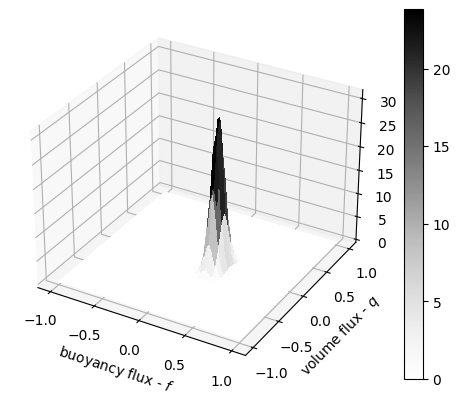

Elapsed time (s) = 1.189518e-02
Conserved mass: int_v P dv = 0.9999786882886761


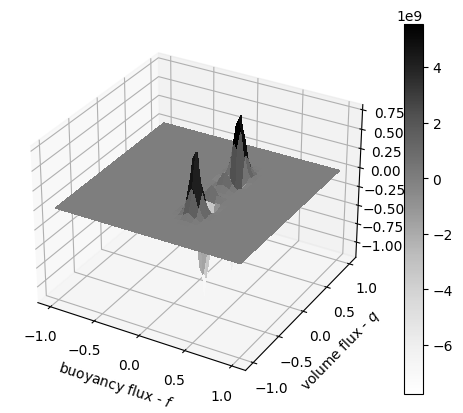

In [118]:
# Solver class for plumes equation
class PlumesFokkerPlanck(FD_Solve):

    """
    Solver class derived from FD solve which solves the Foker-planck equation underlying the plume equations forced by a Wiener process

    Inputs
    -N grid-size (int)
    -domain (dictionary) e.g.  {'name':'x','interval':(-1,1)}

    Methods:
    -init
    -operator
    -Histogram
    """


    def __init__(self,Fi,Nsq,z, N,domain,dt=0.01,endTime=10.):


        # Initialise the base clas
        super().__init__(N,domain,dt,endTime)

        # Set the system parameters
        self.δ   =-0.25
        self.D_F = 0.0
        self.D_Q = 0.0

        # Stratification
        self.Nsq = Nsq
        self.z   = z

        # build the drift & Diffusion terms
        self.Drift_μ()

        # Probability Field
        Pdf = lambda x,μ,σ: (1./(σ*np.sqrt(2.*π)))*np.exp(-.5*( (x - μ)/σ )**2)
        self.P = np.kron( Pdf(self.f,μ=Fi,σ=0.25*abs(Fi)), Pdf(self.q,μ=ε,σ=0.1) )
        print('Initial mass =',np.sum(self.P*self.dV))

    def Drift_μ(self):

      # Create the nonlinear part
      II = sparse.eye(self.N);
      D  = self.Grad();
      self.Df = pow(self.df,-1)*sparse.kron( D, II);
      self.Dq = pow(self.dq,-1)*sparse.kron( II, D);

      # (2) Create flat arrays of each of these vectors using Kronecker product
      I = np.ones(self.N)
      f = np.kron(self.f,I)
      q = np.kron(I,self.q)

      # (3) Create the vector field
      #self.F = lambda z: -np.interp(z,self.z,self.Nsq)*q;
      self.F = lambda z: -q;
      self.Q = lambda z: q/z + (3**4/2**6)*( (z**4 * self.δ**4 * π**2)/(q**2) )*f

      return None

    def Lin_operator(self):

      """
      Build the lineat diffusion term

      L = - [ D_F ∂^2P/∂f^2 + D_Q ∂^2P/∂q^2 ]

      """

      # (1) Create a 2D mass matrix by using the kronecker product
      II     = sparse.eye(self.N);
      Lap    = self.Laplacian();
      Lap_ff = self.D_F*pow(self.df,-2)*sparse.kron(Lap,II)
      Lap_qq = self.D_Q*pow(self.dq,-2)*sparse.kron(II,Lap)

      return -sparse.csr_matrix(Lap_ff + Lap_qq)

    def NLin_operator(self,P,z):

      """
      Build the nonlinear drift term

      F(P,z) = −∂/∂f[(−N^2(z)q)*P]−∂/∂q[(q/z + (3^4/2^6)*(δ^4 π^2 z^4)/(q^2) f)*P]

      """

      return -self.Df@(self.F(z)*P) - self.Dq@(self.Q(z)*P)

    def Histogram(self):

        P = self.P;
        N = self.N;

        # Add plotting here
        # P is structured as ~ (X kron Y) kron Z
        # Reconstruct this as a 3D matrix
        W = P.reshape( (N,N) );

        fig = plt.figure()
        X, Y = np.meshgrid(self.f, self.q)
        #cf = plt.pcolormesh(X,Y,H.T,cmap='Greys',vmax=np.max(H)) # Normalise this + show the colour bar ,norm="log"
        ax = fig.add_subplot(111, projection='3d')
        surf = ax.plot_surface(X, Y, W.T, cmap='Greys',linewidth=0, antialiased=False)
        ax.set_xlabel(r'buoyancy flux - $f$')
        ax.set_ylabel(r'volume flux - $q$')

        fig.colorbar(surf)
        plt.show()

        return None

x_basis = {'name':'f','interval':(-1,1)}
y_basis = {'name':'q','interval':(-1,1)}

Nsq= 1*(z/z)
Fi = 0.2

FP = PlumesFokkerPlanck(Fi,Nsq,z,N=64,domain=[x_basis,y_basis],dt=1e-04,endTime=5e-04);
FP.t+=ε # to avoid the singularity
FP.Histogram()
FP.Time_Integrate(θ = 1.0)
FP.Histogram()

In [ ]:
Q = 0*z
F = 0*z
for F_key,F_value in Plumes.items():

  print(F_key,F_value)
  Fi,Qi  = Plume_Solve_Fokker_Planck(F_value,Nsq,samples = 10**3)
  Plot_F_and_Q(Fi,Qi)
  F+=Fi; Q+=Qi

Plot_F_and_Q(F,Q)

Equipped with a means to obtain the velocity field we can now combine this with the 1D advection diffusion equation for buoyancy
\begin{equation*}
\frac{\partial b}{\partial t} + \bar{w} \frac{\partial b}{\partial z} = \frac{\partial }{\partial z} \Big( \Gamma \frac{\partial b}{\partial z} \Big),
\end{equation*}
where
\begin{equation*}
\bar{w}(z) = -\frac{1}{A} \sum_i Q_i(z),
\end{equation*}
and $\Gamma$ is a turbulent diffusion. To do we solve the advection diffusion equation for buoyancy $b(z,t)$ as below, where $\Gamma$ is taken as a constant.

In [ ]:
def step_buoyancy(w,b,Γ=.1,Δt=1e-03,A_inv = None, B = None):

    """
    Step forward using one time-step

    if Γ > 0:
    Crank-Nicolson
    elif Γ == 0
    Euler-Explicit

    returns b(z,t_n+1)
    """

    if Γ > 0:

      if (A_inv is None) and (B is None):
        A = (I/Δt - .5*Γ*L)
        B = (I/Δt + .5*Γ*L)
        return np.linalg.solve(A,B@b - w*(D@b) )
      else:
        return A_inv@( B@b - w*(D@b) )

    elif Γ == 0:

      #Courant number |c*dt/dx| < 1
      c = np.max(abs(w))
      while  (c*Δt)/dz > 1.:
        dt *=0.5

      return b - Δt*w*(D@b)

With a solver developed for the plume equations and for the 1D buoyancy equations we now link these routines together to establish the background stratification profile for a given set of plume sources and sinks. We consider the case of two opposing plumes of equal strength. \\

We first specify initial conditions for the rising plume
\begin{align}
  F_1(z=0) &= .1, \\
  Q_1(z=0) &= 0, \\
\end{align}
the sinking plume
\begin{align}
  F_2(z=1) &=-.1, \\
  Q_2(z=1) &= 0, \\
\end{align}
and the initial stratification
\begin{equation}
  db/dz(z,t_0=0) = 1.
\end{equation}
Using these boundary conditions we then:
- Solve the plume equations using $db/dz(z,t_n)$ for each of the plumes to obtain $Q_i^n$
- Compute $\bar{w}(z,t_n)$ from the sum of the plumes's volume fluxes $Q_i^n$
- Timestep the 1D buoyancy equation forward from $t_n \to t_n + \Delta t$ to update $db/dz(z,t_n)$ \\

This process is repeated until the residual error
\begin{equation}
  || db^{n+1}/dz - db^{n}/dz ||_2/||db^{n}/dz || < \text{tol},
\end{equation}
falls below a user prescribed tolerance.

In [ ]:
def Strat_solve(b,Plumes,Γ=1e-02,Δt=1e-03,Area=1.0,Iterations=10**4,method=None):

  A_inv = np.linalg.inv(I/Δt - .5*Γ*L)
  B     = (I/Δt + .5*Γ*L)

  Error = [1.0];
  iter  = 0;
  Nsq   = D@b;

  while (iter < Iterations):

    # (1) solve plume equations
    w = 0*z
    for F_key,F_value in Plumes.items():

      if method =='Monte_Carlo':
        Q_i= Plume_Solve_Monte_Carlo(F_value,Nsq,samples = 100)[1]
      elif method =='Fokker_Planck':
        Q_i= Plume_Solve_Fokker_Planck(F_value,Nsq,samples = 10)[1]
      else:
        Q_i= Plume_Solve(F_value,Nsq)[1]

      w -= Q_i/Area

    # (2) step db/dt forward
    b = step_buoyancy(w,b,Γ=Γ,Δt=Δt,A_inv=A_inv,B=B)

    # (3) update N^2 & check converged
    Error.append(  np.linalg.norm(Nsq - D@b,2)/np.linalg.norm(Nsq,2) )
    Nsq   = D@b;
    iter += 1.

    if iter%(Iterations//10) ==0:
      print('Iteration i = %d, Residual error r_i = %e \n'%(iter,Error[-1]))
      Plot_F_and_Q(w,b,label_f='w(z)',label_q='b(z)')

  return Error,w,b;

In [ ]:
# Sources and IC
b      = 1*z;
Plumes = {'F1':.1,'F2':-.1}

# Solve
Error,w,b = Strat_solve(b,Plumes,Iterations=10**3,method='Monte_Carlo')

plt.ylabel(r'$|N^2_{i+1} - N^2_i|_2/|N^2_i|_2$')
plt.xlabel(r'Iteration $i$')
plt.semilogy(Error)
plt.show()

Plot_F_and_Q(w  ,b  ,label_f='w(z)'    ,label_q='b(z)'  )
Plot_F_and_Q(D@w,D@b,label_f='dw(z)/dz',label_q='N^2(z)')